### Train and Split Dataset

In [1]:


# Imports
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch libraries
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Grayscale

In [2]:
transform = Compose([
    ToTensor(),
])
cifar10_data = datasets.CIFAR10(
    root='data',
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [01:45<00:00, 1610703.08it/s]


Extracting data\cifar-10-python.tar.gz to data


In [3]:
# Print the number of samples in the loaded dataset
print(f"Number of samples: {len(cifar10_data)}")
print(f"Class names: {cifar10_data.classes}")

Number of samples: 50000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Label: horse
Image size: torch.Size([3, 32, 32])


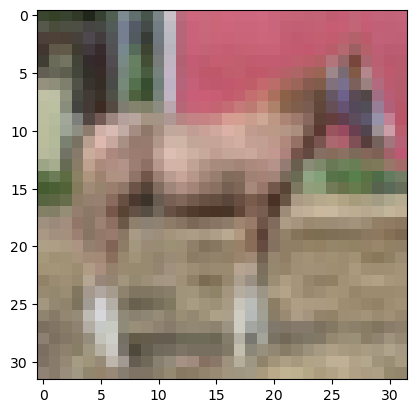

In [4]:
# Choose a random sample
import matplotlib.pyplot as plt
import random
random.seed(2021)


image, label = cifar10_data[random.randint(0, len(cifar10_data))]
print(f"Label: {cifar10_data.classes[label]}")
print(f"Image size: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.show()

In [5]:
transform = Compose([
    ToTensor(),
])
training_data = datasets.CIFAR10(
    root='data',
    train = True,
    download=True,
    transform=transform
)

test_data = datasets.CIFAR10(
    root='data',
    train= False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


### Datasets and Dataloaders

In [6]:
# def seed_worker(worker_id):
#   worker_seed = torch.initial_seed() % 2**32
#   numpy.random.seed(worker_seed)
#   random.seed(worker_seed)


# g_seed = torch.Generator()
# g_seed.manual_seed(my_seed)

# DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     num_workers=num_workers,
#     worker_init_fn=seed_worker,
#     generator=g_seed
#     )
# Create dataloaders with
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Batch size: torch.Size([64, 3, 32, 32])


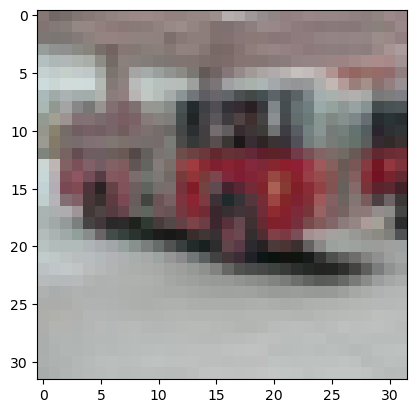

In [7]:


# Load the next batch
batch_images, batch_labels = next(iter(train_dataloader))
print('Batch size:', batch_images.shape)

# Display the first image from the batch
plt.imshow(batch_images[0].permute(1, 2, 0))
plt.show()

#### Data Augmentation - Transformations

Files already downloaded and verified


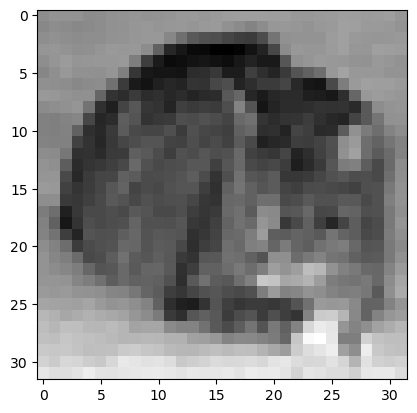

In [8]:
def my_data_load():
    data = datasets.CIFAR10(
        root = 'data',
        download= True,
        transform=Compose([ToTensor(), Grayscale()])
    )
    image, label = data[random.randint(0, len(data))]
    plt.imshow(image.permute(1, 2, 0), cmap="gray")
    plt.show()

    return data

# Set the random seed
seed = 2021
torch.manual_seed(seed)
## After implementing the above code, uncomment the following lines to test your code
data = my_data_load()

In [19]:
from sklearn.datasets import make_moons
import pandas as pd

# Create a dataset of 256 points with a little noise
X, y = make_moons(256, noise=0.1)
df = pd.DataFrame(dict(x0 = X[:, 0], x1 = X[:, 1], y = y))
df.to_csv("sample_data.csv")

Size X:(256, 2)
Size y:(256,)


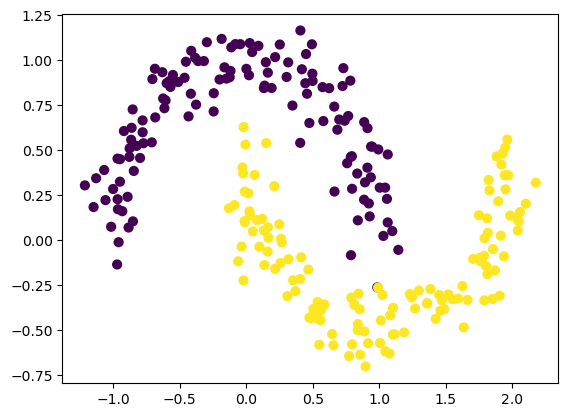

In [27]:

# Load the data from the CSV file in a Pandas DataFrame
data = pd.read_csv("sample_data.csv")

# Create a 2D numpy array from the x0 and x1 columns
X_orig = data[["x0", "x1"]].to_numpy()

# Create a 1D numpy array from the y column
y_orig = data["y"].to_numpy()

# Print the sizes of the generated 2D points X and the corresponding labels Y
print(f"Size X:{X_orig.shape}")
print(f"Size y:{y_orig.shape}")
plt.scatter(X_orig[:, 0], X_orig[:, 1], s = 40, c = y_orig)
plt.show()


In [29]:
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [35]:
# @title Helper function to plot the decision boundary

# Code adapted from this notebook: https://jonchar.net/notebooks/Artificial-Neural-Network-with-Keras/

from pathlib import Path

def plot_decision_boundary(model, X, y, device):
  """
  Helper function to plot decision boundary

  Args:
    model: nn.module
      NaiveNet instance
    X: torch.tensor
      Input CIFAR10 data
    y: torch.tensor
      Class Labels/Targets
    device: String
      "cpu" or "cuda"

  Returns:
    Nothing
  """
  # Transfer the data to the CPU
  X = X.cpu().numpy()
  y = y.cpu().numpy()

  # Check if the frames folder exists and create it if needed
  frames_path = Path("frames")
  if not frames_path.exists():
    frames_path.mkdir()

  # Set min and max values and give it some padding
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  h = 0.01

  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Predict the function value for the whole gid
  grid_points = np.c_[xx.ravel(), yy.ravel()]
  grid_points = torch.from_numpy(grid_points).type(torch.FloatTensor)
  Z = model.predict(grid_points.to(device)).cpu().numpy()
  Z = Z.reshape(xx.shape)

  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)

In [30]:
# Initialize the device variable
DEVICE = set_device()

# Convert the 2D points to a float32 tensor
X = torch.tensor(X_orig, dtype=torch.float32)

# Upload the tensor to the device
X = X.to(DEVICE)

print(f"Size X:{X.shape}")

# Convert the labels to a long interger tensor
y = torch.from_numpy(y_orig).type(torch.LongTensor)

# Upload the tensor to the device
y = y.to(DEVICE)

print(f"Size y:{y.shape}")

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu
Size X:torch.Size([256, 2])
Size y:torch.Size([256])


Epoch 0 loss is 0.6670800447463989
Epoch 1000 loss is 0.24978971481323242
Epoch 2000 loss is 0.22733984887599945
Epoch 3000 loss is 0.1993328183889389
Epoch 4000 loss is 0.16293160617351532
Epoch 5000 loss is 0.1267334520816803
Epoch 6000 loss is 0.09801200032234192
Epoch 7000 loss is 0.0778915286064148
Epoch 8000 loss is 0.06421823054552078
Epoch 9000 loss is 0.054676514118909836
Epoch 10000 loss is 0.04764772951602936
Epoch 11000 loss is 0.04237250238656998
Epoch 12000 loss is 0.038349591195583344
Epoch 13000 loss is 0.035168323665857315
Epoch 14000 loss is 0.03257723152637482
Epoch 15000 loss is 0.030430633574724197
Epoch 16000 loss is 0.028628377243876457
Epoch 17000 loss is 0.02708839438855648
Epoch 18000 loss is 0.025758160278201103
Epoch 19000 loss is 0.024595515802502632


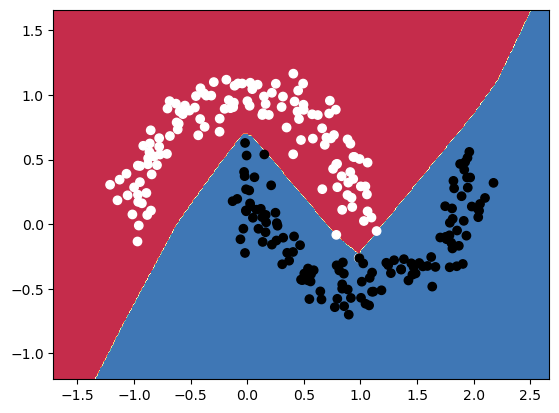

In [49]:
# Inherit from nn.Module - the base class for neural network modules provided by Pytorch
class NaiveNet(nn.Module):
  """
  NaiveNet architecture
  Structure is as follows:
  Linear Layer (2, 16) -> ReLU activation -> Linear Layer (16, 2)
  """
  # Define the structure of your network
  def __init__(self):
    """
    Defines the NaiveNet structure by initialising following attributes
    nn.Linear (2, 16):  Transformation from the input to the hidden layer
    nn.ReLU: Activation function (ReLU) is a non-linearity which is widely used because it reduces computation.
             The function returns 0 if it receives any negative input, but for any positive value x, it returns that value back.
    nn.Linear (16, 2): Transformation from the hidden to the output layer

    Args:
      None

    Returns:
      Nothing
    """
    super(NaiveNet, self).__init__()

    # The network is defined as a sequence of operations
    self.layers = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 2),
    )

  # Specify the computations performed on the data
  def forward(self, x):
    """
    Defines the forward pass through the above defined structure

    Args:
      x: torch.Tensor
        Input tensor of size ([3])

    Returns:
      layers: nn.module
        Initialised Layers in order to re-use the same layer for each forward pass of data you make.
    """
    # Pass the data through the layers
    return self.layers(x)

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Performs the prediction task of the network

    Args:
      x: torch.Tensor
        Input tensor of size ([3])

    Returns:
      Most likely class i.e., Label with the highest score
    """
    # Pass the data through the networks
    output = self.forward(x)

    # Choose the label with the highest score
    return torch.argmax(output, 1)

    # Train the neural network (will be implemented later)
  # Implement the train function given a training dataset X and correcsponding labels y
def train(model, X, y):
  """
    Training the Neural Network

    Args:
      X: torch.Tensor
        Input data
      y: torch.Tensor
        Class Labels/Targets

    Returns:
      losses: Float
        Cross Entropy Loss; Cross-entropy builds upon the idea of entropy
        from information theory and calculates the number of bits required
        to represent or transmit an average event from one distribution
        compared to another distribution.
    """
  # The Cross Entropy Loss is suitable for classification problems
  loss_function = nn.CrossEntropyLoss()

  # Create an optimizer (Stochastic Gradient Descent) that will be used to train the network
  learning_rate = 2e-2
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Number of epochs
  epochs = 20000

  # List of losses for visualization
  losses = []

  for i in range(epochs):
    # Pass the data through the network and compute the loss
    # We'll use the whole dataset during the training instead of using batches
    # in to order to keep the code simple for now.
    y_logits = model.forward(X)
    loss = loss_function(y_logits, y)

    # Clear the previous gradients and compute the new ones
    optimizer.zero_grad()
    loss.backward()

    # Adapt the weights of the network
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

    # Print the results at every 1000th epoch
    if i % 1000 == 0:
      print(f"Epoch {i} loss is {loss.item()}")

      plot_decision_boundary(model, X, y, DEVICE)
      plt.savefig('frames/{:05d}.png'.format(i))

  return losses


# Create a new network instance a train it
model = NaiveNet().to(DEVICE)
losses = train(model, X, y)

In [37]:
## Get the samples
X_samples = X[0:5]
print("Sample input:\n", X_samples)

## Do a forward pass of the network
output = model.forward(X_samples)
print("\nNetwork output:\n", output)

## Predict the label of each point
y_predicted = model.predict(X_samples)
print("\nPredicted labels:\n", y_predicted)

Sample input:
 tensor([[-0.4620,  0.9024],
        [-0.1991,  0.8928],
        [ 1.7884, -0.3333],
        [ 0.6460, -0.5199],
        [ 0.4756, -0.4287]])

Network output:
 tensor([[ 3.0927, -1.6599],
        [ 2.4218, -0.8907],
        [-2.4668,  4.1168],
        [-1.8569,  2.7410],
        [-1.9387,  2.8092]], grad_fn=<AddmmBackward0>)

Predicted labels:
 tensor([0, 0, 1, 1, 1])


Text(0, 0.5, 'Loss')

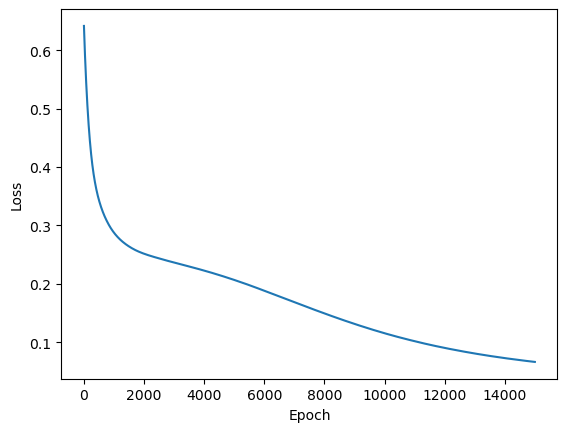

In [38]:
plt.plot(np.linspace(1, len(losses), len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

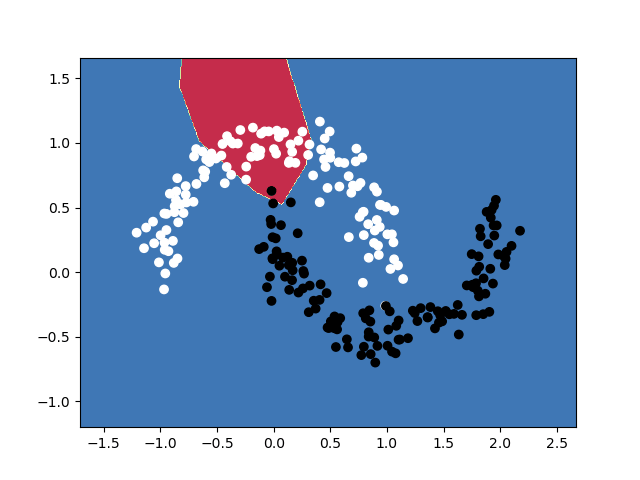

In [39]:
# @title Visualize the training process
# @markdown Execute this cell!
!pip install imageio --quiet
!pip install pathlib --quiet

import imageio.v2 as imageio
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image, display
from pathlib import Path

InteractiveShell.ast_node_interactivity = "all"

# Make a list with all images
images = []
for i in range(10):
  filename = Path("frames/0"+str(i)+"000.png")
  images.append(imageio.imread(filename))
# Save the gif
imageio.mimsave('frames/movie.gif', images)
gifPath = Path("frames/movie.gif")
with open(gifPath,'rb') as f:
  display(Image(data=f.read(), format='png'))